<a href="https://colab.research.google.com/github/tsachiblau/sparseGANProject/blob/master/GAN_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

setting up data

In [2]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = './drive/My Drive/Documents/Master/semester 1/sparse/sparse representation project/files/current/'


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


settings parameters

In [0]:
import numpy as np
from keras.optimizers import Adam
#set seed
np.random.seed(10)

#train params
steps_per_epoch = 3750  # batch_size * steps_per_epoch = epoch size (train size)
epochs = 100
optimizer = Adam(0.0002, 0.5)

#gan param
noise_dim = 100

#images params
img_rows, img_cols, channels = 28, 28, 1
batch_size = 16
half_batch_size = int(batch_size/2)

#sparse params
sparse_dim = img_rows * img_cols * channels
L1_weight = 10   # Loss = data_fidelity + L1_weight * L1_norm
max_iter_of_dict = 1
thr_value = 0.05


functions 


In [0]:
def imageToDictionaryImage(d, X):
  representation_vec = d.transform(X)
  representation_vec = np.transpose(representation_vec)
  ans = np.matmul(dictionary_loaded2,representation_vec)
  return ans, representation_vec

def show_images(noise):
    generated_images = generator.predict(noise)
    generated_images = np.matmul(dictionary_loaded2,np.transpose(generated_images))
    generated_images = np.transpose(generated_images)
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


def show_original_images(number_of_rows):
    
    generated_images = x_train[np.random.randint(x_train.shape[0], size = number_of_rows*10), :]
    plt.figure(figsize=(10, 10))
    
    for i, image in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


def my_loss(y_actual,y_pred):
  #return kullback_leibler_divergence(y_actual,y_pred)
  #return 0.5*(kullback_leibler_divergence(y_actual,y_pred) + binary_crossentropy(y_actual,y_pred))
  return binary_crossentropy(y_actual,y_pred)

def soft_threshlding(x):
  above_thr_pos = x * cast(x >= thr_value, tf.float32)
  below_thr_neg = x * cast(x <= -thr_value, tf.float32)
  return (above_thr_pos + below_thr_neg)

def stop_criteria(fake_x):
  d_pred = np.sum(discriminator.predict(fake_x))/fake_x.shape[0]
  return d_pred >= 0.599

def d_ratio_on_fake(fake_x):
  return np.sum(discriminator.predict(fake_x))/fake_x.shape[0]

def count_support(sparse_mat):
  return (np.count_nonzero(sparse_mat))/sparse_mat.shape[0]

def numberOfStepsForDiscriminator(losses):
  size_of_chunck = 5
  
  x1 = 0.3
  x2 = 0.4
  x3 = 0.5
  y1 = 1.0
  y2 = 3.0
  y3 = 10.0

  N = len(losses)

  if N == 0:
    return 1

  if N < size_of_chunck:
    size_of_chunck = N

  last_five_average = np.mean(losses[N - size_of_chunck:])

  if last_five_average < x1:
    number_of_steps = 1

  elif last_five_average < x2:
    m = (y2 - y1) / (x2 - x1)
    n = y1 - m * x1
    number_of_steps = m * last_five_average + n

  else:
    m = (y3 - y2) / (x3 - x2)
    n = y2 - m * x2
    number_of_steps = m * last_five_average + n

  return int(number_of_steps)


import data set

In [103]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train.astype(np.float32) - 127.5) / 127.5  # normalize between +1 -1

x_train = x_train.reshape(-1, img_rows*img_cols*channels) # each image as vector

np.random.shuffle(x_train)
print(x_train.shape)

(60000, 784)


*Train* or load sparse dictionary:

In [104]:
import matplotlib.pyplot as plt
from sklearn.decomposition import DictionaryLearning
import pickle
import os.path
from os import path

#dictionary file name
file_path = 'dictionary.pkl'
retrain_model = False

#check if dictionary exists
if not path.exists(drive_path + file_path):
  max_iter_of_dict = 1
  sparse_dim = 3000
  d=DictionaryLearning(n_components=sparse_dim, max_iter=max_iter_of_dict)
  # train dictionary
  d.fit(x_train[1:10000, :])
  dictionary = d.components_
  print(dictionary.shape)

  with open(drive_path + file_path, 'wb') as output:
    pickle.dump(d, output, pickle.HIGHEST_PROTOCOL)
  print("created new dictionary")

else:
  with open(drive_path + file_path, 'rb') as input:
    d = pickle.load(input)
  # print(d)
  print("loaded dictionary")

  if retrain_model == True:
    max_iter_of_dict = 40
    print("start retrain for ", str(max_iter_of_dict), " iteration")
    d.fit(x_train[1:10000, :])
    dictionary = d.components_
    print(dictionary.shape)
    print("train for ", str(max_iter_of_dict) ," more iter")
    file_path = 'new_dictionary.pkl'
    with open(file_path, 'wb') as output:
      pickle.dump(d, output, pickle.HIGHEST_PROTOCOL)
    print("created new dictionary")



dictionary_loaded2 = np.transpose(d.components_)
dictionary_loaded2 = np.array(dictionary_loaded2, dtype = np.float32)
print(dictionary_loaded2.shape)


loaded dictionary
(784, 784)


**sanity** check

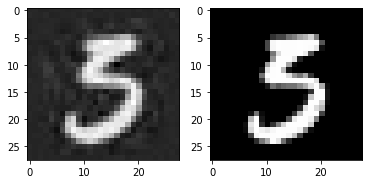

In [105]:

sample_num = np.random.randint(x_train.shape[0])

ans, _ = imageToDictionaryImage(d, x_train[sample_num:sample_num+1,:])

plt.figure()
plt.subplot(121)
plt.imshow(ans.reshape((img_rows, img_cols)), cmap='gray')
plt.subplot(122)
real_im = x_train[sample_num:sample_num+1,:]
plt.imshow(real_im.reshape((img_rows, img_cols)), cmap='gray')



extend dataset


In [106]:
new_data_name = 'new_data'
N = x_train.shape[0]

if path.exists(drive_path + new_data_name + '.npy'):
  x_train = np.load(drive_path + new_data_name + '.npy')
  new_rep = np.load(drive_path + new_data_name + '_rep.npy')
  print("loaded new data")

else:
  print("NO")
  #create the data
  new_images = []
  new_rep = []
  for i in range(N):
    img, perpesenation = imageToDictionaryImage(d, x_train[i:i + 1,:])
    new_images.append(img)
    new_rep.append(perpesenation)

    if np.mod(i, 1000) == 0:
      print("finished ", str(i), "/", str(N))
  
  #save it 

  a = np.array(new_images)
  a = a.reshape(a.shape[0], a.shape[1])
  x_train = a

  np.save(drive_path + new_data_name, x_train)
  new_rep = np.array(new_rep)
  new_rep = new_rep.squeeze()
  np.save(drive_path + new_data_name + "_rep", new_rep)
  print("saved the new data")

loaded new data


show the histogram of the representatin vectors


the mean is:  1.3031963532128066
the median is:  0.9201149046421051


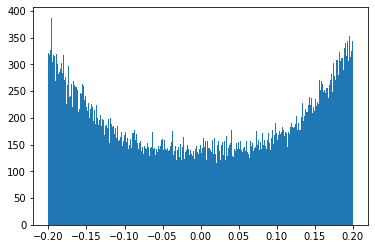

In [107]:
%matplotlib inline
tmp = new_rep[new_rep != 0]
plt.figure()
plt.hist(tmp, bins = 1000, range=(-0.2, 0.2));
print("the mean is: ", str(np.mean(np.abs(tmp))))
print("the median is: ", str(np.median(np.abs(tmp))))

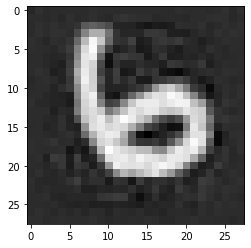

In [109]:
#show new data 
random_num = np.random.randint(N)
tmp_img = x_train[random_num, :]
plt.figure()
plt.imshow(tmp_img.reshape((img_rows, img_cols)), cmap='gray')

extende dataset

Model: "Gen"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
init (Dense)                 (None, 256)               25856     
_________________________________________________________________
BN1 (BatchNormalization)     (None, 256)               1024      
_________________________________________________________________
Activation1 (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
hidden1 (Dense)              (None, 512)               131584    
_________________________________________________________________
BN2 (BatchNormalization)     (None, 512)               2048      
_________________________________________________________________
Activation2 (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
hidden2 (Dense)              (None, 1024)              525312  

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


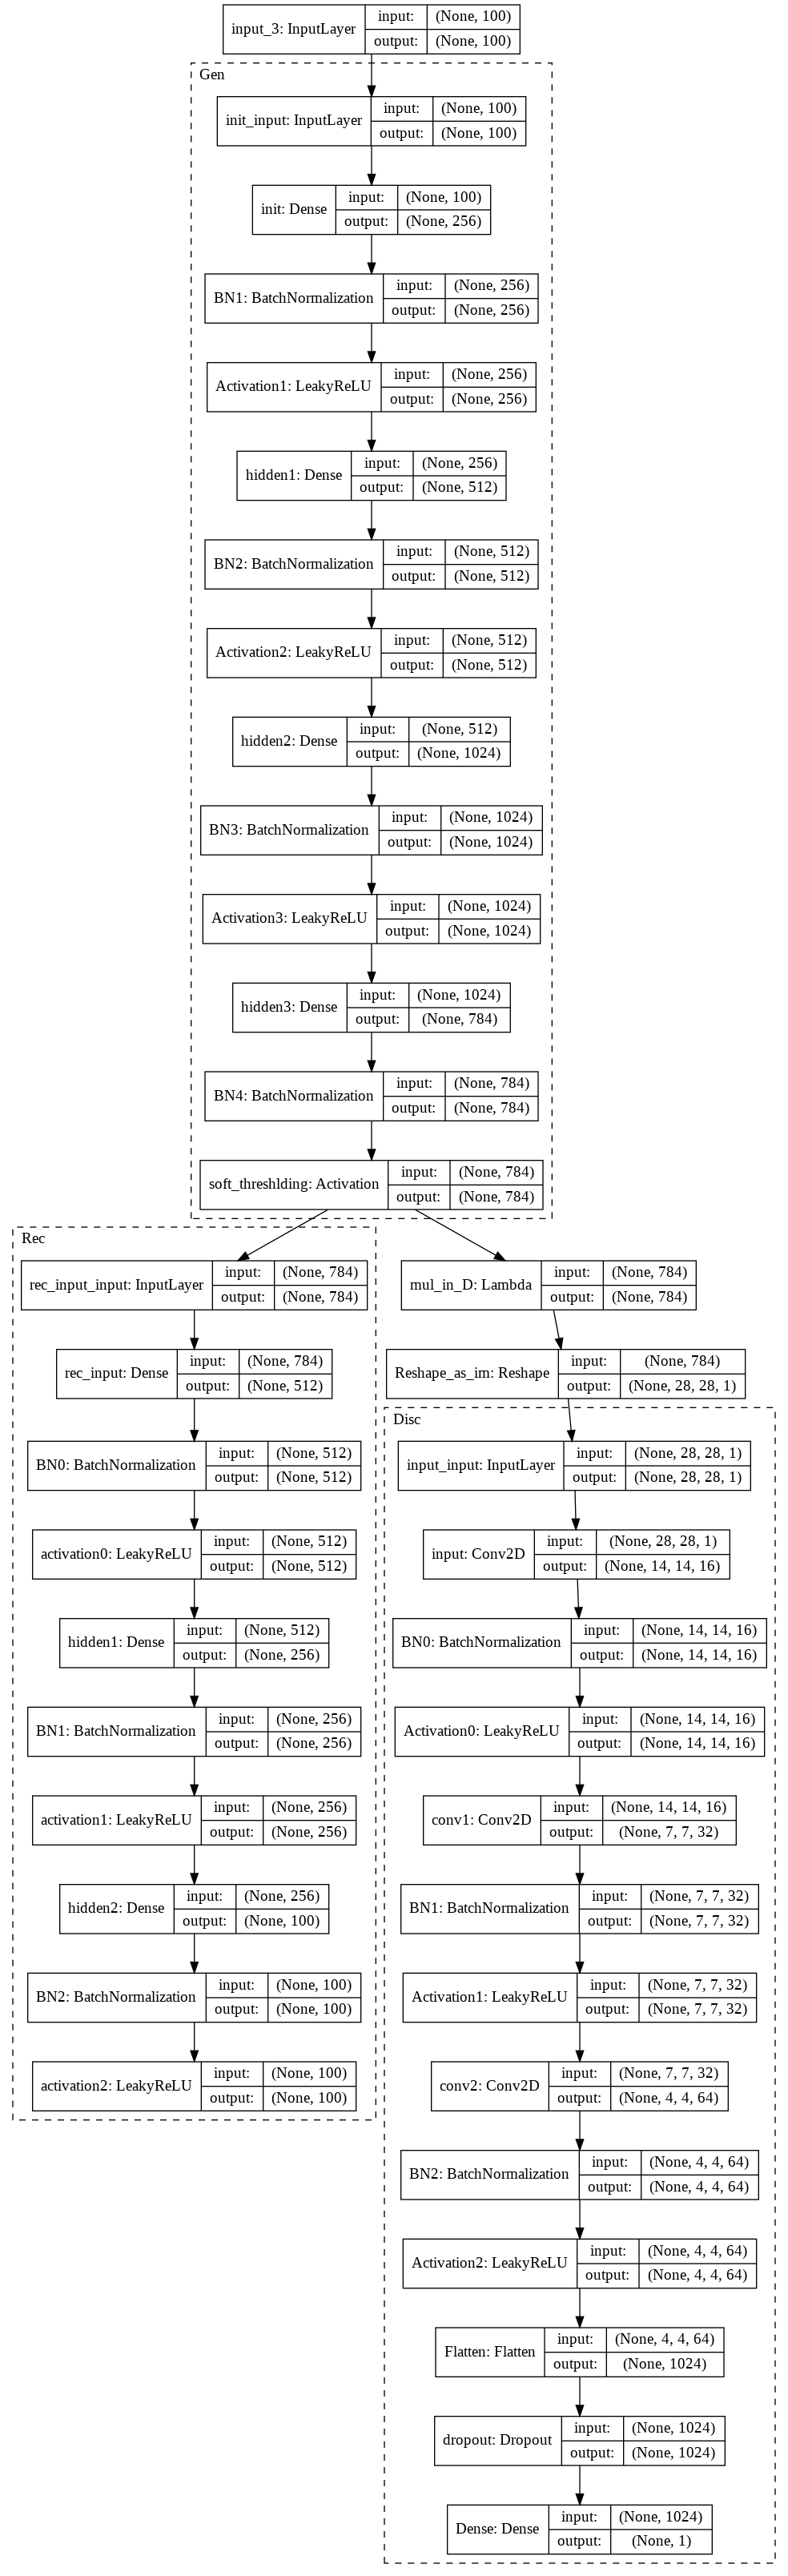

In [110]:
# with pursuit and thresholding approach
# generator:
from keras.utils import plot_model
from keras.models import Sequential
from keras import backend as K
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Input
from keras.models import Model
from keras.initializers import RandomNormal, glorot_uniform
from keras.layers import Dense, Conv2D, Flatten, Reshape, Dropout, AveragePooling2D, MaxPooling2D, BatchNormalization, Lambda, ReLU, ThresholdedReLU, Activation
from tensorflow.linalg import matmul, matrix_transpose
from tensorflow.math import abs
from keras import regularizers
from keras.losses import kullback_leibler_divergence, binary_crossentropy


from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from tensorflow import cast

# costum loss - symmetric KL divergence

def my_loss(y_actual,y_pred):
  #return kullback_leibler_divergence(y_actual,y_pred)
  #return 0.5*(kullback_leibler_divergence(y_actual,y_pred) + binary_crossentropy(y_actual,y_pred))
  return binary_crossentropy(y_actual,y_pred)


# would cause small entries in absulute values to be set to zero and will create sparse vectors
def soft_threshlding(x):
  above_thr_pos = x * cast(x >= thr_value, tf.float32)
  below_thr_neg = x * cast(x <= -thr_value, tf.float32)
  return (above_thr_pos + below_thr_neg)

get_custom_objects().update({'soft_threshlding': Activation(soft_threshlding)})

# input: sparse vec size
# output: noise size
def create_reconstructor():
    reconstructor = Sequential()
    init = RandomNormal(0,stddev=0.02)

    reconstructor.add(Dense(512,  kernel_initializer=init, input_dim=sparse_dim,name="rec_input"))
    reconstructor.add(BatchNormalization(name="BN0"))
    reconstructor.add(LeakyReLU(0.2,name="activation0"))

    reconstructor.add(Dense(256, kernel_initializer=init,name="hidden1"))
    reconstructor.add(BatchNormalization(name="BN1"))
    reconstructor.add(LeakyReLU(0.2,name="activation1"))

    reconstructor.add(Dense(noise_dim, kernel_initializer=init,name="hidden2"))
    reconstructor.add(BatchNormalization(name="BN2"))
    reconstructor.add(LeakyReLU(0.2,name="activation2"))

    #reconstructor.compile(loss='mean_squared_error', optimizer='sgd')
    return reconstructor

# input: noise size
# output: sparse vec size
def create_generator():
    generator = Sequential()
    init = RandomNormal(0,stddev=0.02)
    generator.add(Dense(256, kernel_initializer=init, input_dim=noise_dim,name="init"))
    generator.add(BatchNormalization(name="BN1"))
    generator.add(LeakyReLU(0.2,name="Activation1"))

    generator.add(Dense(512,kernel_initializer=init,name="hidden1"))
    generator.add(BatchNormalization(name="BN2"))
    generator.add(LeakyReLU(0.2,name="Activation2"))

    generator.add(Dense(1024,kernel_initializer=init,name="hidden2"))
    generator.add(BatchNormalization(name="BN3"))
    generator.add(LeakyReLU(0.2,name="Activation3"))

    generator.add(Dense(sparse_dim, kernel_initializer=init,name="hidden3"))
    # soft thresholding activation
    generator.add(BatchNormalization(name="BN4"))
    generator.add(Activation(soft_threshlding, name='soft_threshlding'))
    return generator

# input: image size
# output: 1 number - 1 real 0 fake
# descriminator:
def create_descriminator():
    discriminator = Sequential()
    #16 - better
    discriminator.add(Conv2D(16, (3, 3), strides=(2,2),padding='same', kernel_regularizer=regularizers.l2(0.01),kernel_initializer=RandomNormal(0, 0.02), input_shape=(img_cols, img_rows, channels),name="input"))
    discriminator.add(BatchNormalization(name="BN0"))
    discriminator.add(LeakyReLU(0.2,name="Activation0"))
    #32 - better
    discriminator.add(Conv2D(32, (3, 3), strides=(2,2), padding='same',  kernel_regularizer=regularizers.l2(0.01),kernel_initializer=RandomNormal(0, 0.02),name="conv1"))
    discriminator.add(BatchNormalization(name="BN1"))
    discriminator.add(LeakyReLU(0.2,name="Activation1"))
    # 64 - better
    discriminator.add(Conv2D(64, (3, 3), strides=(2,2), padding='same',  kernel_regularizer=regularizers.l2(0.01),kernel_initializer=RandomNormal(0, 0.02),name="conv2"))
    discriminator.add(BatchNormalization(name="BN2"))
    discriminator.add(LeakyReLU(0.2,name="Activation2"))
    
    discriminator.add(Flatten(name="Flatten"))
    discriminator.add(Dropout(0.4,name="dropout"))
    discriminator.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01),kernel_initializer=RandomNormal(0, 0.02),name="Dense"))   # 1 number which indicates real / fake
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

# build GAN
discriminator = create_descriminator()
generator = create_generator()
reconstructor = create_reconstructor()
# naming:
discriminator.name = "Disc"
generator.name = "Gen"
reconstructor.name = "Rec"
#
discriminator.trainable = False   # will be trained separately, not as GAN

gan_input = Input(shape=(noise_dim,))

# G(z) is a sparse vector
sparse_vec = generator(gan_input)   # sparse_dim size - it is thresholded

# a layer that creates the multiplication between the sparse tensor with dictionary to create image
fake_image_vec = Lambda(lambda x: matrix_transpose(matmul(dictionary_loaded2,matrix_transpose(x))),name='mul_in_D')(sparse_vec)
# reshape to image size - will be inserted to discriminator
fake_image = Reshape((img_rows, img_cols, channels),name="Reshape_as_im")(fake_image_vec)

gan_output = discriminator(fake_image)  # the descriminator output
vae_output = reconstructor(sparse_vec)  # the reconstructor output

vae = Model(gan_input, vae_output)
vae.compile(loss='mean_squared_error', optimizer='sgd')

# todo - double output double loss
gan = Model(gan_input, [gan_output,sparse_vec])
gan.compile(loss=[my_loss,'mean_absolute_error'], optimizer=optimizer,loss_weights=[1,L1_weight])

print(generator.summary())
print(discriminator.summary())
print(reconstructor.summary())
complete = Model(gan_input,[gan_output,vae_output])
plot_model(complete, to_file='model_plot.png', show_shapes=True, show_layer_names=True,expand_nested=True)


2nd approach train

In [117]:
stop = False
fake_x = 0

losses = np.array([])
iters= np.array([])

n_d = 1 # 1 10 100
n_g = 1  # 1 10 100
n_r = 1  # 1 10 100


for epoch in range(epochs):  #epochs
    for iter in range(int(steps_per_epoch)):
      i = iter + int(epoch*(steps_per_epoch))
    
      # train D
      for batch in range(n_d):  #steps_per_epoch
          noise = np.random.normal(0, 1, size=(half_batch_size, noise_dim))  # will generate batch amount of noise vectors (gaussian distribution)
          fake_x = generator.predict(noise) # create G(z)
          # fake is (half_batch_size,sparse_dim)
          
          fake_x = np.transpose(fake_x)
          # multiply by dict
          fake_x = np.matmul(dictionary_loaded2,fake_x)

          fake_x = np.transpose(fake_x)
          fake_x = fake_x.reshape(half_batch_size,img_rows,img_cols,channels)
          # fake_x is of size (half_batch_size,rows,cols,channels)

          real_x = x_train[np.random.randint(0, x_train.shape[0], size=half_batch_size)] # sample real image
          #remove below to return to FC scheme
          real_x = real_x.reshape(fake_x.shape)

          x = np.concatenate((real_x, fake_x))
          
          disc_y = np.zeros(2*half_batch_size)
          disc_y[:half_batch_size] = 0.9
          # [0.9 ... 0 ...]

          # train_on_batch recieves data and desired output
          d_loss_real = discriminator.train_on_batch(real_x, disc_y[:half_batch_size])
          d_loss_fake = discriminator.train_on_batch(fake_x, disc_y[half_batch_size:])

      # train G
      for batch in range(n_g):  #steps_per_epoch
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))  # will generate batch amount of noise vectors (gaussian distribution)
        # train GAN (descriminator weights are fixed)
        y_gen_1 = np.ones(batch_size)
        y_gen_2 = np.zeros(batch_size * sparse_dim)
        y_gen_2 = y_gen_2.reshape(batch_size,sparse_dim)
        # TODO train the two outputs
        g_loss = gan.train_on_batch(noise, [y_gen_1,y_gen_2])
            
      # train R
      for batch in range(n_r):  #steps_per_epoch
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))  # will generate batch amount of noise vectors (gaussian distribution)
        r_loss = vae.train_on_batch(noise[:batch_size],noise[:batch_size])

      ########################################################## statistics ########################################################## 
      if(epoch>0 and stop_criteria(fake_x)):
        print("converged in epoch "+str(epoch))
        show_images(noise)
        stop = True
        break

      # print temp results
      if(i%100==0):
        losses = np.append(losses,d_ratio_on_fake(fake_x))
        iters =  np.append(iters,i)

      if(stop):
        break
        
    n_d = numberOfStepsForDiscriminator(losses)
    print(f'Epoch: {epoch + 1} \t Discriminator Loss_fake: {d_loss_fake} \t Discriminator Loss_real: {d_loss_real}\t\t Generator Loss: {g_loss}')
    plt.plot(iters,losses)
    plt.show()
    noise = np.random.normal(0, 1, size=(100, noise_dim))
    show_images(noise)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


KeyboardInterrupt: ignored

show 100 results

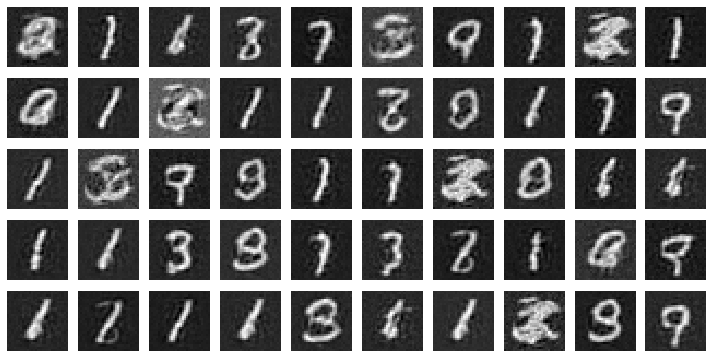

###########################################################################################
######################################original images######################################
###########################################################################################


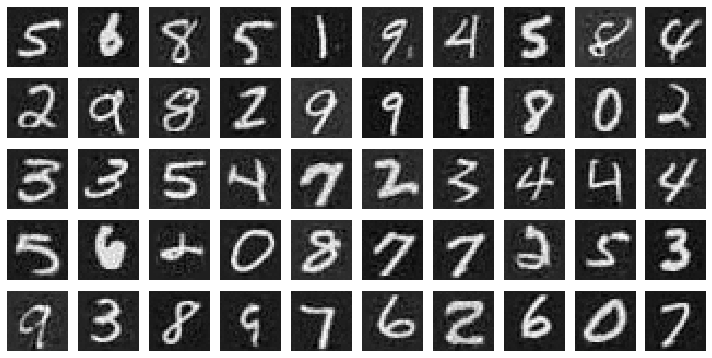

In [39]:
noise = np.random.normal(0, 1, size=(50, noise_dim))
show_images(noise)
print('###########################################################################################')
print('######################################original images######################################')
print('###########################################################################################')
show_original_images(5)